<a href="https://colab.research.google.com/github/benspniz/Company-Application-Tasks/blob/master/Task-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Loading the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# importing the sys module 
import sys 
sys.setrecursionlimit(10**6) 

In [3]:
#Loading the dataset
task2_path = '/content/sample_data/california_housing_train.csv'
raw_df = pd.read_csv(task2_path)

In [4]:
#Viewing the dataset
raw_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [5]:
#Creating a copy of the dataframe to work with
df = raw_df.copy()

# Task 2

In [6]:
#Method to view heatmap of a correlation matrix dataframe
def heatMap(df):
  upper = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))         #Creating dataframe out of the upper triangle of the correlation matrix
  plt.figure(figsize = (20, 15))
  s = sns.heatmap(upper,
                   annot = True, 
                   cmap = 'RdYlGn',
                   vmin = -1, 
                   vmax = 1)
  s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
  s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
  plt.title('Correlation Heatmap')
  plt.show()

In [7]:
#Feature selection class to eliminate multicollinearity
class MultiCollinearityEliminator():
 
  #Class Constructor
  def __init__(self, df, target, threshold):
    self.df = df
    self.target = target
    self.threshold = threshold

  #Method to create and return the feature correlation matrix dataframe
  def createCorrMatrix(self):
    #Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
    #Setting min_period to 30 for the sample size to be statistically significant (normal) according to central limit theorem
    corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()
    return corrMatrix

  #Method to create and return the feature to target correlation matrix dataframe
  def createCorrMatrixWithTarget(self):
    #After obtaining the list of correlated features, this method will help to view which variables (in the list of correlated features) are least correlated with the target
    #This way, out the list of correlated features, we can ensure to elimate the feature that is least correlated with the target
    #This not only helps to sustain the predictive power of the model but also helps in reducing model complexity
    corrMatrix = self.createCorrMatrix()                                                #Obtaining the correlation matrix of the dataframe
    corrWithTarget = pd.DataFrame(corrMatrix.loc[:,self.target]).drop([self.target], axis = 0).sort_values(by = self.target)                   #Creating the required dataframe, then dropping the target row and sorting by the value of correlation with target (in asceding order)   
    return corrWithTarget

  #Method to create and return the list of correlated features
  def createCorrelatedFeaturesList(self):
    corrMatrix = self.createCorrMatrix()                                                #Obtaining the correlation matrix of the dataframe
    colCorr = []        
    for column in corrMatrix.columns:                                                   #Iterating through the columns of the correlation matrix dataframe
      for idx, row in corrMatrix.iterrows():                                            #Iterating through the values (row wise) of the correlation matrix dataframe
        if(row[column]>self.threshold) and (row[column]<1) and (idx not in colCorr):
          colCorr.append(idx)
    return colCorr

  #Method to eliminate the least important features from the list of correlated features
  def deleteFeatures(self):                                     
    corrWithTarget = self.createCorrMatrixWithTarget()                                  #Obtaining the feature to target correlation matrix dataframe
    colCorr = self.createCorrelatedFeaturesList()                                       #Obtaining the list of correlated features 
    for idx, row in corrWithTarget.iterrows():
      if (idx in colCorr):
        self.df = self.df.drop(idx, axis =1)
        break
    return self.df

  #Method to run automatically eliminate multicollinearity
  def autoEliminateMulticollinearity(self):
    corrMatrix = self.createCorrMatrix()                                                #Obtaining the correlation matrix of the dataframe   
    corrWithTarget = self.createCorrMatrixWithTarget()                                  #Obtaining the feature to target correlation matrix dataframe
    colCorr = self.createCorrelatedFeaturesList()                                       #Obtaining the list of correlated features
    while colCorr != []:
      self.df = self.deleteFeatures()                                                   #Obtaining the dataframe after deleting the feature (from the list of correlated features) that is least correlated with the taregt
      corrMatrix = self.createCorrMatrix()                                              #Obtaining the correlation matrix of the dataframe   
      corrWithTarget = self.createCorrMatrixWithTarget()                                #Obtaining the feature to target correlation matrix dataframe
      colCorr = self.createCorrelatedFeaturesList()                                     #Obtaining the list of correlated features
    return self.df

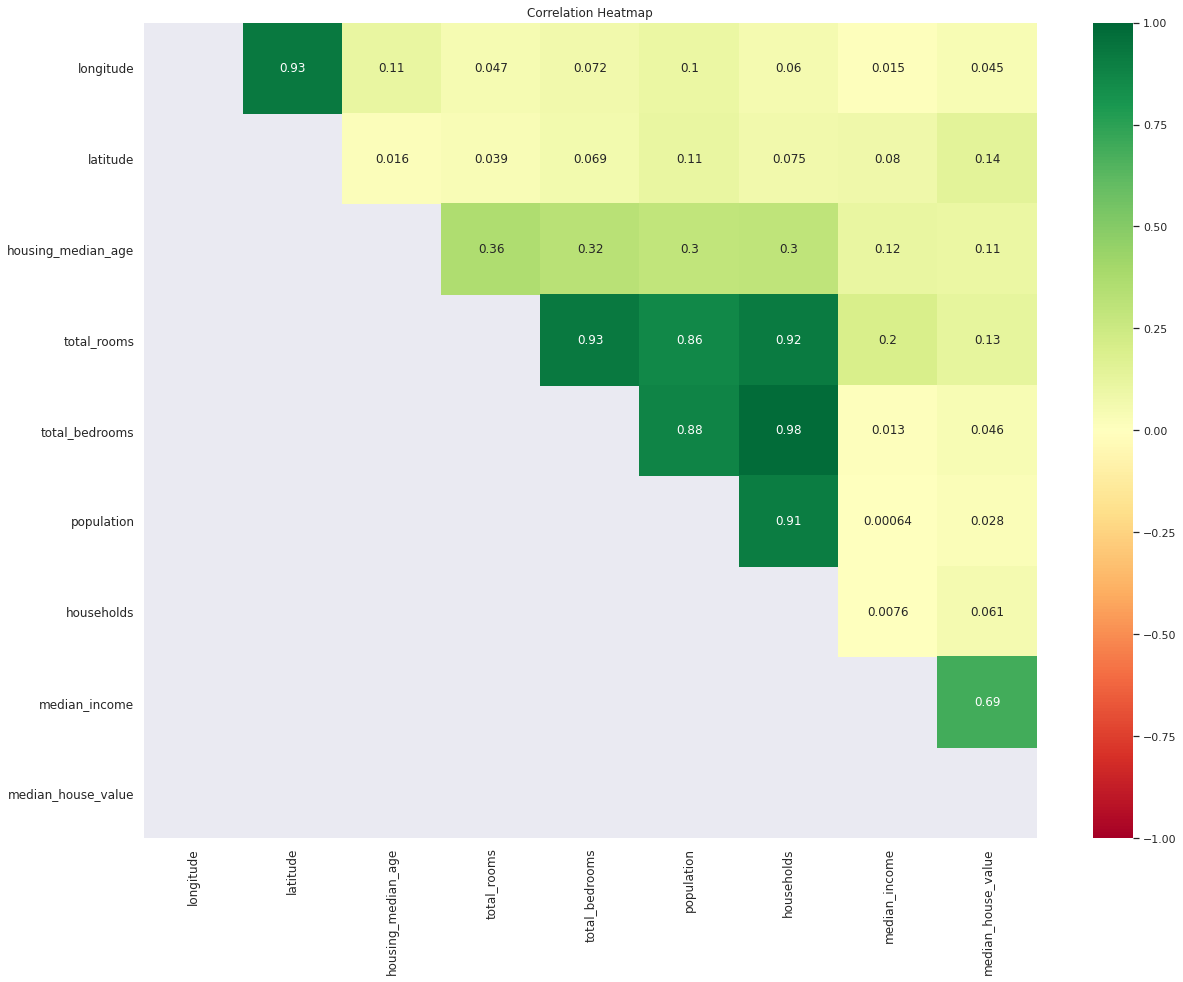

In [8]:
start_df = df.copy()
startCorrMatrix = start_df.corr(method='pearson', min_periods=30).abs()
heatMap(startCorrMatrix)

In [9]:
multiCollinearityEliminator = MultiCollinearityEliminator(df, 'median_house_value', 0.85)

In [10]:
final_df = multiCollinearityEliminator.autoEliminateMulticollinearity()

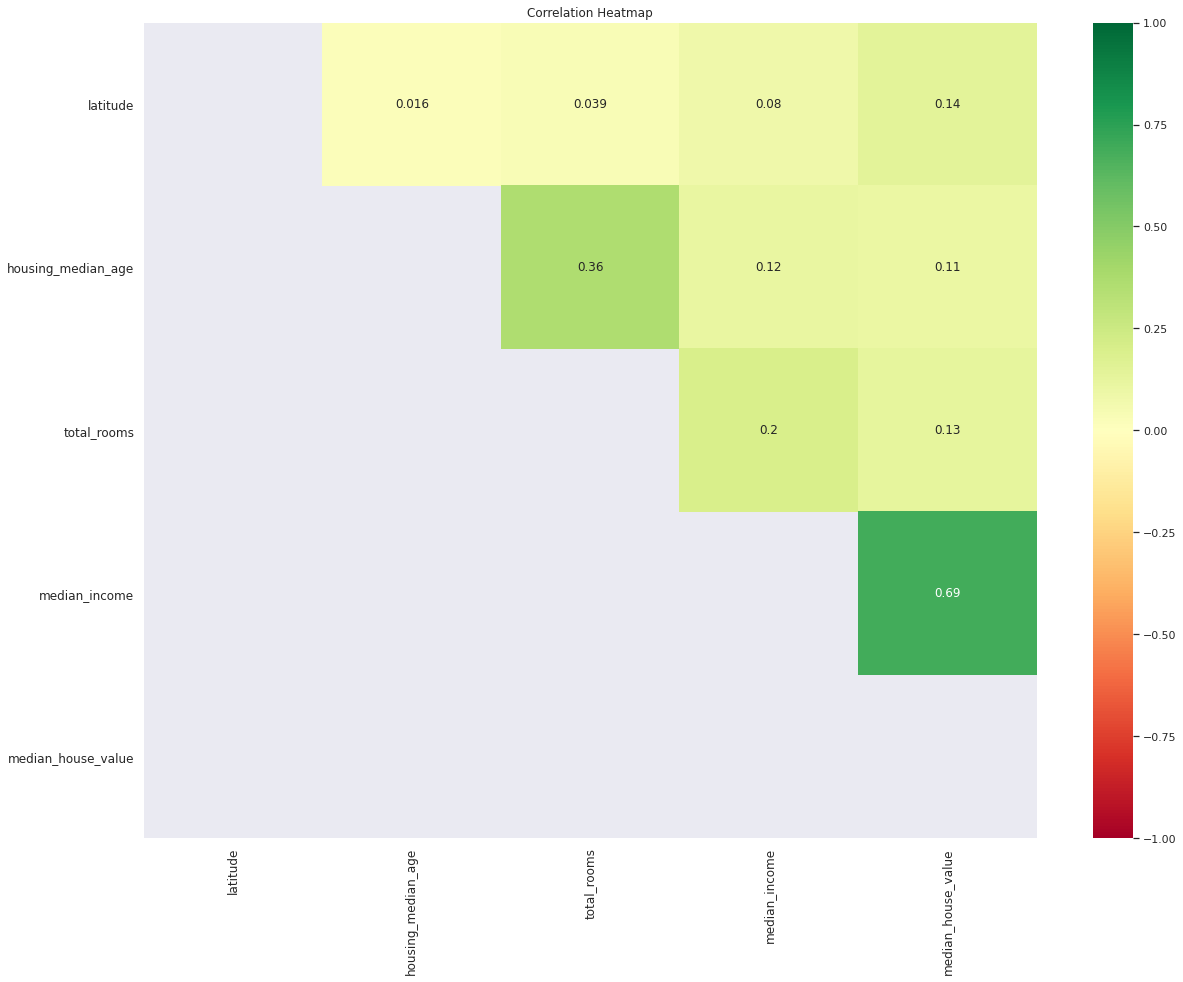

In [11]:
finalCorrMatrix = final_df.corr(method='pearson', min_periods=30).abs()
heatMap(finalCorrMatrix)